This code performs PCA (feature reduction), K-means clustering and creates a text file with centroid-molecule associations from it.






In [1]:
import glob
import os
import itertools
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.DataStructs import FingerprintSimilarity
import numpy as np
from sklearn.decomposition import PCA
import csv
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### MFP_matrix

`AllChem.GetMorganFingerprintAsBitVect(mol, 2`) is used to generate the Morgan fingerprint for each molecule in `mol_list`.
_The Morgan fingerprint_ is a type of circular fingerprint that represents the molecular structure of a compound. 
The 2 in the function call specifies the radius of the circular fingerprint. This means that the fingerprint will capture structural information up to **two bonds** away from each atom.

`itertools.product(fp, repeat=2)` generates all possible pairs of fingerprints from the fp. 
Then `FingerprintSimilarity(x, y)` calculetes similiraty score between x and y (all combinations generated by itertools.product from the list `fp`) and store them in the `mfps` list.

Finally, we convert the `mfps` list into a Numpy array that is reshaped into a a square matrix. 


In [2]:
def MFP_matrix(mol_list):
    fp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in mol_list] #  list fp containing Morgan fingerprints for all molecules in mol_list.
    mfps = list(FingerprintSimilarity(x, y) for x, y in itertools.product(fp, repeat=2))  
    return fp, np.array(mfps).reshape(len(fp), len(fp))

In order to this to work the sdf must be in the following format:

    'target_ligands.sdf'

/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


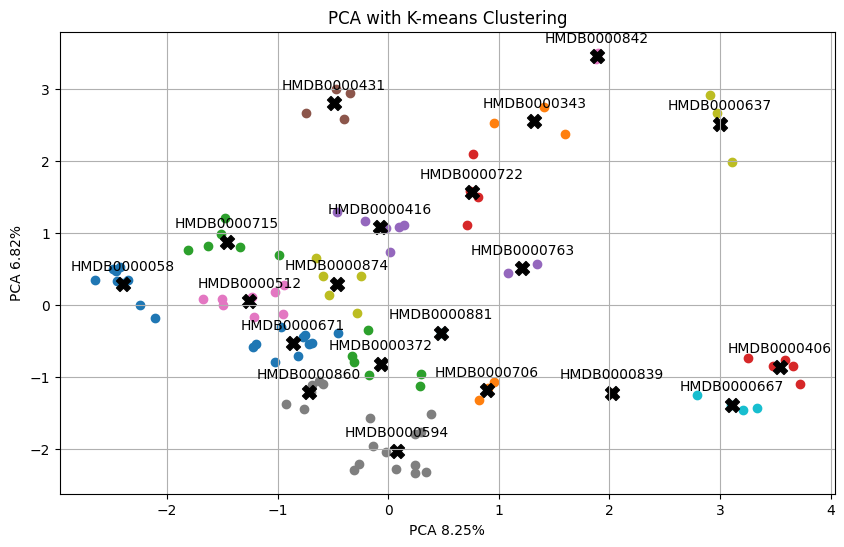

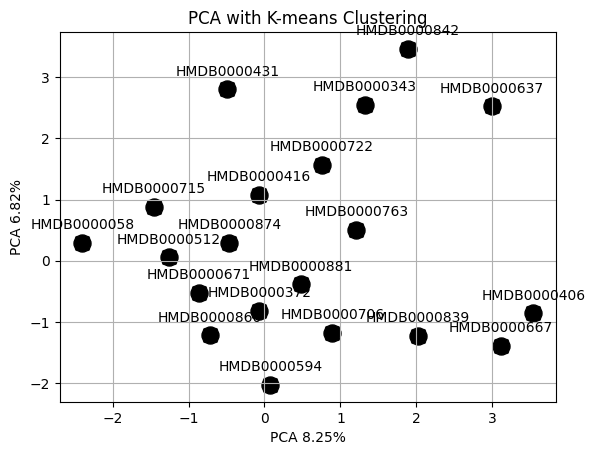

In [3]:
target = 'RKC' # Change this to your target name

# Locate SDF file

path = glob.glob('{}'.format(os.getcwd())+f'/{target}*.sdf')
sdf_path = path[0]

# Load molecular data using SDMolSupplier
suppl = Chem.SDMolSupplier(sdf_path)
fp_list, fp_mat = MFP_matrix(suppl)
name_list = [mol.GetProp('_Name') for mol in suppl]

# Store data in dictionary
target_data = {
    target: {
        'fp_list': fp_list,
        'name_list': name_list
    }
}

# PCA for feature reduction 
fps = [target_data[target]['fp_list']]
flat_fps = np.array([fp for target in fps for fp in target])
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(flat_fps)


# Apply k-means clustering
num_clusters = 20  # Number of clusters
kmeans = KMeans(n_init=10, n_clusters=num_clusters)
kmeans.fit(pca_coords)
cluster_labels = kmeans.labels_

# Apply k-means clustering
num_clusters = 20  # Number of clusters
kmeans = KMeans(n_init = 10, n_clusters=num_clusters)
kmeans.fit(pca_coords)
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Visualization 

# Create a scatter plot
plt.figure(figsize=(10, 6))
for cluster_id in range(num_clusters):
    cluster_points = pca_coords[cluster_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1])

# Annotate centroids with molecule names
for i, (x, y) in enumerate(centroids):
    plt.scatter(x, y, c='black', marker='X', s=100)
    plt.annotate(target_data[target]['name_list'][i], (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('PCA with K-means Clustering')
plt.xlabel('PCA {}%'.format(round(pca.explained_variance_ratio_[0] * 100, 2)))
plt.ylabel('PCA {}%'.format(round(pca.explained_variance_ratio_[1] * 100, 2)))
plt.grid()
plt.show()

# Plot cluster centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', color='black', s=150, label='Centroids')
for i, (x, y) in enumerate(centroids):
    plt.scatter(x, y, c='black', marker='x', s=100)
    plt.annotate(target_data[target]['name_list'][i], (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('PCA with K-means Clustering')
plt.xlabel('PCA {}%'.format(round(pca.explained_variance_ratio_[0] * 100, 2)))
plt.ylabel('PCA {}%'.format(round(pca.explained_variance_ratio_[1] * 100, 2)))
plt.grid()
plt.show()



# Create a dictionary to store centroid-molecule associations
centroid_molecule_association = {target_data[target]['name_list'][i]: [] for i in range(num_clusters)}

# Populate the dictionary with molecule names
for idx, cluster_id in enumerate(cluster_labels):
    centroid_molecule_association[target_data[target]['name_list'][cluster_id]].append(target_data[target]['name_list'][idx])

# Populate the dictionary with molecule names
for idx, cluster_id in enumerate(cluster_labels):
    centroid_molecule_association[target_data[target]['name_list'][cluster_id]].append(target_data[target]['name_list'][idx])

# Write the centroid-molecule associations to a text file
with open(f'{target}-centroids.txt', 'w') as file:
    for centroid, molecules in centroid_molecule_association.items():
        file.write(f"Centroid: {centroid}\n")
        for molecule in molecules:
            file.write(f"{molecule}\n")
        file.write("\n")


# CSV file for writing
with open(f'{target}-cluster.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header
    csvwriter.writerow(['Molecule Name', 'Cluster Label', 'Is Centroid'])
    z = 0
    for i in centroid_molecule_association.keys():
        z +=1
        csvwriter.writerow([i, z, 'Yes'])
        for mol in centroid_molecule_association[i]:
            csvwriter.writerow([mol, z, 'No'])